In [23]:
# We continue playing around with F vs NF groups following week 9 meeting
import astropy.io.fits as fits
import numpy as np
from astropy.table import unique,Table,setdiff,hstack,join
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import warnings
from scipy.stats import sem
import random
warnings.filterwarnings("ignore")

data = Table.read('/suphys/fscu5535/python_scripts/mod_data/massGaps7.3.fits',memmap=True)

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

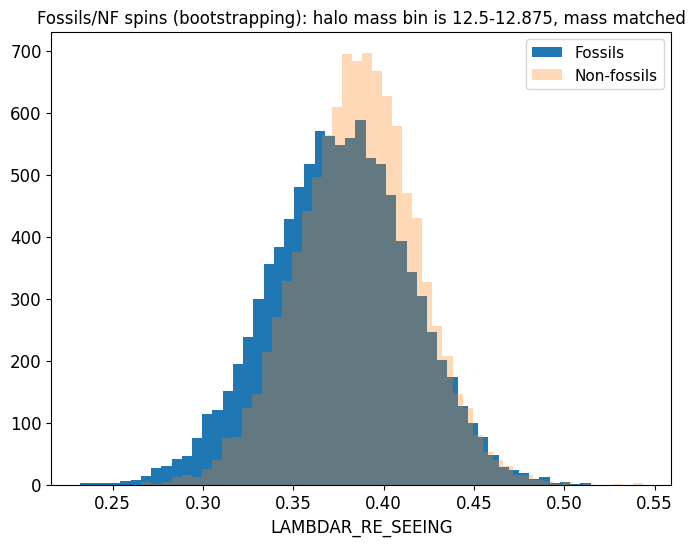

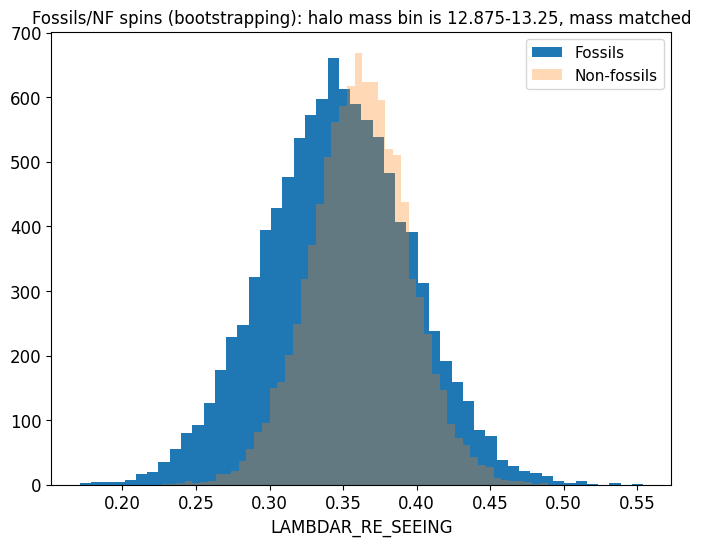

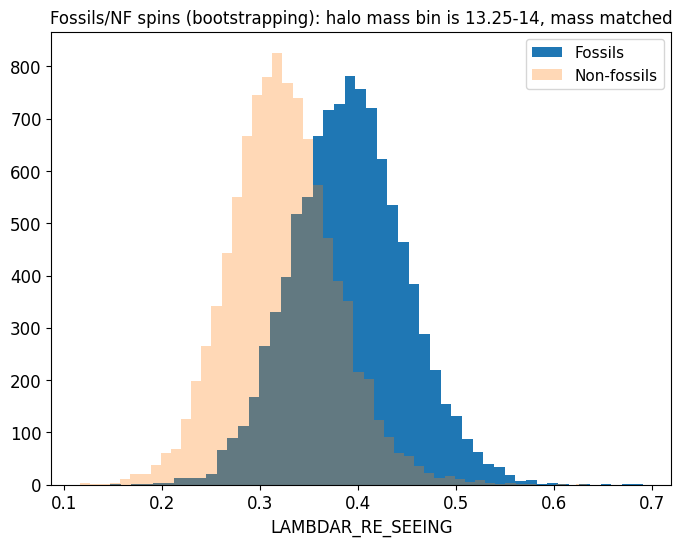

In [20]:
# separate F from NF, using different bins of halo mass (TO AVOID CORRELATIONS)
# our bins will be: bin 1 [12.5,13], bin 2 = 13+
# USING SEEING CORRECTED SPINS ONLY
# AND using 16th/84th percentiles for error

# these are the halo mass cuts that we will bin our data into
haloMassCuts = [12.5,12.875,13.25,14]

meanmatchedfossilspins = [[],[],[],[],[],[]]
meanmatchedNFspins = [[],[],[],[],[],[]]
meanmatchedfossilerrorsupper = [[],[],[],[],[],[]]
meanmatchedfossilerrorslower = [[],[],[],[],[],[]]
meanmatchedNFerrorsupper = [[],[],[],[],[],[]]
meanmatchedNFerrorslower = [[],[],[],[],[],[]]

SEMmatchedfossilspins = [[],[],[],[],[],[]]
SEMmatchedNFspins = [[],[],[],[],[],[]]
SEMmatchedfossilerrors = [[],[],[],[],[],[]]
SEMmatchedNFerrors = [[],[],[],[],[],[]]

# use bootstrapping!
N = len(data)

N_expts = 10000

for h in range(N_expts):

    fossilspins = []
    NFspins = []
    fossilmasses = []
    NFmasses = []
    fossilmassgaps = []
    NFmassgaps = []
    fossilage = []
    NFage = []

    matchedfossilspins = []
    matchedNFspins = []
    matchedfossilmasses = []
    matchedNFmasses = []
    matchedfossilmassgaps = []
    matchedNFmassgaps = []
    matchedfossilage = []
    matchedNFage = []

    # indices that we will select (identical to sampling with replacement)
    indices = np.random.randint(N, size = N) 

    # loop over our halo mass bins
    for i in range(1,len(haloMassCuts)):
        fossilspins.append([])
        NFspins.append([])
        fossilmasses.append([])
        NFmasses.append([])
        fossilmassgaps.append([])
        NFmassgaps.append([])
        fossilage.append([])
        NFage.append([])

        matchedfossilspins.append([])
        matchedNFspins.append([])
        matchedfossilmasses.append([])
        matchedNFmasses.append([])
        matchedfossilmassgaps.append([])
        matchedNFmassgaps.append([])
        matchedfossilage.append([])
        matchedNFage.append([])


        # now loop over our galaxies and divide them into F and NF AND the right bin!
        for j in indices:

            if haloMassCuts[i-1] < data['log(MassA)'][j] < haloMassCuts[i] and str(data['LAMBDAR_RE_SEEING'][j]) != 'nan':       

                if data['m1-IntMean'][j] > 0.97:              
                    fossilspins[i-1].append(data['LAMBDAR_RE_SEEING'][j])
                    fossilmasses[i-1].append(data['m1'][j])
                    fossilmassgaps[i-1].append(data['m1-IntMean'][j])
                    #fossilage[i-1].append(data['linage_LW_1Re'][j]/10e9)
                else:
                    NFspins[i-1].append(data['LAMBDAR_RE_SEEING'][j])
                    NFmasses[i-1].append(data['m1'][j])
                    NFmassgaps[i-1].append(data['m1-IntMean'][j])
                    #NFage[i-1].append(data['linage_LW_1Re'][j]/10e9)

        # set mass match maximum difference (in dex)
        maxdiff = 0.15
        #maxdiffage = 0.1
        NFindicesshuffled = np.linspace(0,len(NFmasses[i-1])-1,len(NFmasses[i-1]),dtype=int)
        random.shuffle(NFindicesshuffled)

        # run through the fossils
        for j in range(len(fossilmasses[i-1])):

            # run through the NF's until we find one that is within maxdiff dex of our F and
            # is not an NF that we've matched yet
            
            for k in NFindicesshuffled:
                if abs(fossilmasses[i-1][j] - NFmasses[i-1][k]) < maxdiff and NFmasses[i-1][k] not in matchedNFmasses[i-1]:

                    matchedfossilspins[i-1].append(fossilspins[i-1][j])
                    matchedfossilmasses[i-1].append(fossilmasses[i-1][j])
                    matchedfossilmassgaps[i-1].append(fossilmassgaps[i-1][j])
                    #matchedfossilerrors[i-1].append(fossilerrors[i-1][j])

                    matchedNFspins[i-1].append(NFspins[i-1][k])
                    matchedNFmasses[i-1].append(NFmasses[i-1][k])
                    matchedNFmassgaps[i-1].append(NFmassgaps[i-1][k])
                    #matchedNFerrors[i-1].append(NFerrors[i-1][k])

                    # break out of this inner loop if we find a match and move on to the next fossil
                    break

        # calculate mean of each group
        if (str(np.mean(np.asarray(matchedfossilspins[i-1]))) != 'nan' and
        str(np.mean(np.asarray(matchedNFspins[i-1]))) != 'nan'):                  
            meanmatchedfossilspins[i-1].append(np.mean(np.asarray(matchedfossilspins[i-1])))               
            meanmatchedNFspins[i-1].append(np.mean(np.asarray(matchedNFspins[i-1]))) 
            
#         # calculate STANDARD deviation of each group
#         if (str(np.std(np.asarray(matchedfossilspins[i-1]))) != 'nan' and
#         str(np.mean(np.std(matchedNFspins[i-1]))) != 'nan'):                  
#             SEMmatchedfossilspins[i-1].append(np.std(np.asarray(matchedfossilspins[i-1]))/np.sqrt(len(matchedfossilspins[i-1])))               
#             SEMmatchedNFspins[i-1].append(np.std(np.asarray(matchedNFspins[i-1]))/np.sqrt(len(matchedNFspins[i-1])))


#         plt.figure(figsize=(8, 6), dpi=100)
#         plt.xlim([-0.1,2.75])
#         plt.ylim([-0.05,1.05])
#         fossilmeanplot = plt.plot([-1,3],[meanmatchedfossilspins[i-1],meanmatchedfossilspins[i-1]],'--b')
#         nfmeanplot = plt.plot([-1,3],[meanmatchedNFspins[i-1],meanmatchedNFspins[i-1]],'--r')
#         massgapcut = plt.plot([0.97,0.97],[-0.5,1.5],'k')
#         plt.legend(["Fossils mean spin","NF mean spin","Mass gap cut"])                                     
#         fossilsplot = plt.scatter(matchedfossilmassgaps[i-1],matchedfossilspins[i-1],c=matchedfossilmasses[i-1],cmap='plasma',vmin=9.6,vmax=11.4)
#         nfplot = plt.scatter(matchedNFmassgaps[i-1],matchedNFspins[i-1],c=matchedNFmasses[i-1],cmap='plasma',vmin=9.6,vmax=11.4)
#         plt.title("Comparing Fossils/Non-fossils: halo mass bin is {}-{}, mass matched".format(haloMassCuts[i-1],haloMassCuts[i]))
#         plt.xlabel("Mass gap (dex(Msun))")
#         plt.ylabel("Spin")
#         cbar = plt.colorbar()
#         cbar.set_label('Stellar mass (dex(MSun))')
#         plt.show()


for i in range(3):
    plt.figure(figsize=(8, 6), dpi=100)
    fossilmeanhist = plt.hist(meanmatchedfossilspins[i],bins=50)
    NFmeanhist = plt.hist(meanmatchedNFspins[i],bins=50,alpha=0.3)
    plt.xlabel("LAMBDAR_RE_SEEING")
    plt.title("Fossils/NF spins (bootstrapping): halo mass bin is {}-{}, mass matched".format(haloMassCuts[i],haloMassCuts[i+1]))
    plt.legend(["Fossils","Non-fossils"])
    plt.show()
    
#     # save the plot
#     filename = "/suphys/fscu5535/python_scripts/figures/FossilNonFossilSpinMeansHaloMassBin{}-{}.png".format(haloMassCuts[i-1],haloMassCuts[i])
#     plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)
#     plt.clf()
    

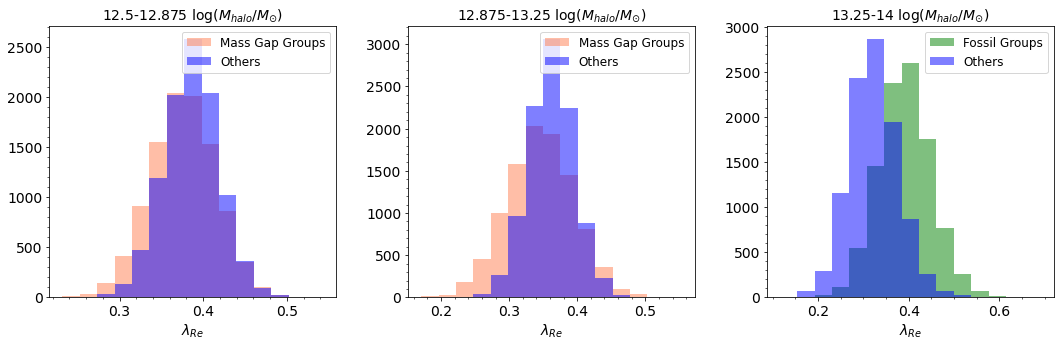

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, gridspec_kw={'wspace' : 0.25}, figsize=(18,5))

i=0
bins=np.histogram(np.hstack((meanmatchedfossilspins[i],meanmatchedNFspins[i])), bins=15)[1] #get the bin edges
ax1.hist(meanmatchedfossilspins[i],bins,alpha=0.5,color='coral')
ax1.hist(meanmatchedNFspins[i],bins,alpha=0.5,color='b')
ax1.set_xlabel(r"$\lambda_{Re}$")
ax1.set_title(r"{}-{} log$(M_{{halo}}/M_{{\odot}})$".format(haloMassCuts[i],haloMassCuts[i+1]))
ax1.legend(["Mass Gap Groups","Others"])
ax1.minorticks_on()

i=1
bins=np.histogram(np.hstack((meanmatchedfossilspins[i],meanmatchedNFspins[i])), bins=15)[1] #get the bin edges
ax2.hist(meanmatchedfossilspins[i],bins,alpha=0.5,color='coral')
ax2.hist(meanmatchedNFspins[i],bins,alpha=0.5,color='b')
ax2.set_xlabel(r"$\lambda_{Re}$")
ax2.set_title(r"{}-{} log$(M_{{halo}}/M_{{\odot}})$".format(haloMassCuts[i],haloMassCuts[i+1]))
ax2.legend(["Mass Gap Groups","Others"])
ax2.minorticks_on()

i=2        
bins=np.histogram(np.hstack((meanmatchedfossilspins[i],meanmatchedNFspins[i])), bins=15)[1] #get the bin edges
ax3.hist(meanmatchedfossilspins[i],bins,alpha=0.5,color='g')
ax3.hist(meanmatchedNFspins[i],bins,alpha=0.5,color='b')
ax3.set_xlabel(r"$\lambda_{Re}$")
ax3.set_title(r"{}-{} log$(M_{{halo}}/M_{{\odot}})$".format(haloMassCuts[i],haloMassCuts[i+1]))
ax3.legend(["Fossil Groups","Others"])
ax3.minorticks_on()
    
        
        
filename = "/suphys/fscu5535/python_scripts/figures/spinbootstrappingpdfs.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

        
        
        
        
        
        
        
        

In [17]:
for i in range(3):
    plt.figure(figsize=(8, 6), dpi=100)
    
    if i <= 1:
        bins=np.histogram(np.hstack((meanmatchedfossilspins[i],meanmatchedNFspins[i])), bins=15)[1] #get the bin edges
        fossilmeanhist = plt.hist(meanmatchedfossilspins[i],bins,alpha=0.5,color='coral')
        NFmeanhist = plt.hist(meanmatchedNFspins[i],bins,alpha=0.5,color='b')
        plt.xlabel(r"$\lambda_{Re}$")
        plt.title(r"{}-{} log(M$_{{halo}}$/M$_{{\odot}}$)".format(haloMassCuts[i],haloMassCuts[i+1]))
        plt.legend(["Mass Gap Group","Other"])
        plt.minorticks_on()
               
    else:
        bins=np.histogram(np.hstack((meanmatchedfossilspins[i],meanmatchedNFspins[i])), bins=15)[1] #get the bin edges
        fossilmeanhist = plt.hist(meanmatchedfossilspins[i],bins,alpha=0.5,color='g')
        NFmeanhist = plt.hist(meanmatchedNFspins[i],bins,alpha=0.5,color='b')
        plt.xlabel(r"$\lambda_{Re}$")
        plt.title(r"{}-{} log(M$_{{halo}}$/M$_{{\odot}}$)".format(haloMassCuts[i],haloMassCuts[i+1]))
        plt.legend(["Fossil Group","Other"])
        plt.minorticks_on()
               
        
    filename = "/suphys/fscu5535/python_scripts/figures/SpinHaloMassBin{}-{}.png".format(haloMassCuts[i],haloMassCuts[i+1])
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)
    plt.clf()
    
    

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [32]:
import scipy as sp
for i in range(3):
    print(sp.stats.kstest(meanmatchedfossilspins[i],meanmatchedNFspins[i]))

KstestResult(statistic=0.1849, pvalue=9.421854309869404e-150)
KstestResult(statistic=0.1233, pvalue=1.2903944812079117e-66)
KstestResult(statistic=0.5972, pvalue=0.0)


0.057691548
0.05450705
0.04930856
0.033330064
0.03892577
0.032855544


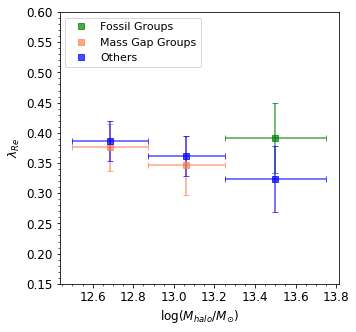

In [22]:
# plot the above
halomasspoints = [12.6875,13.0625,13.5]
halomassbins = np.array([0.1875,0.1875,0.25])

fig, (ax) = plt.subplots(1, 1, figsize=(5,5))
dummy=[]
ax.errorbar(dummy,dummy,fmt='s',c='g',alpha=0.7,label="Fossil Groups")
ax.errorbar(dummy,dummy,fmt='s',c='coral',alpha=0.7,label="Mass Gap Groups")
ax.errorbar(dummy,dummy,fmt='s',c='b',alpha=0.7,label="Others")
ax.legend(loc='upper left')


for i in [2,1,0]:
    fossilmean = np.mean(meanmatchedfossilspins[i])
    fossilspinerror = np.std(meanmatchedfossilspins[i])
    print(fossilspinerror)
    
    NFmean = np.mean(meanmatchedNFspins[i])
    NFspinerror = np.std(meanmatchedNFspins[i])
    print(NFspinerror)
    
    if i == 2:
        fossilserror = ax.errorbar(halomasspoints[i],fossilmean,yerr=fossilspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='g',alpha=0.7)
        nonfossilerrors = ax.errorbar(halomasspoints[i], NFmean,yerr=NFspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='b', alpha = 0.7)
    if i == 1:
        fossilserror = ax.errorbar(halomasspoints[i],fossilmean,yerr=fossilspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='coral',alpha=0.7)
        nonfossilerrors = ax.errorbar(halomasspoints[i], NFmean,yerr=NFspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='b', alpha = 0.7)
    if i == 0:
        fossilserror = ax.errorbar(halomasspoints[i],fossilmean,yerr=fossilspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='coral',alpha=0.7)
        nonfossilerrors = ax.errorbar(halomasspoints[i], NFmean,yerr=NFspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='b', alpha = 0.7)
        
ax.set_ylabel(r"$\lambda_{Re}$")
ax.set_xlabel(r"log$(M_{halo}/M_{\odot})$")
ax.set_ylim(0.15,0.6)
ax.legend(loc='upper left')
ax.minorticks_on()

# save the plot
filename = "/suphys/fscu5535/python_scripts/figures/fossilmggspin.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

0.057082552
0.055075023
0.049220663
0.034038268
0.038978882
0.032584693


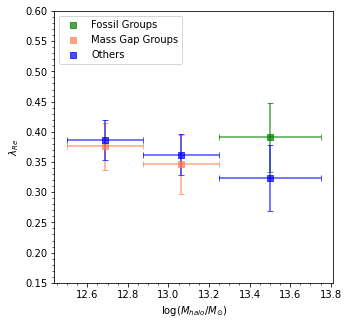

In [17]:
# plot the above
halomasspoints = [12.6875,13.0625,13.5]
halomassbins = np.array([0.1875,0.1875,0.25])

fig, (ax) = plt.subplots(1, 1, figsize=(5,5))
dummy=[]
ax.errorbar(dummy,dummy,fmt='s',c='g',alpha=0.7,label="Fossil Groups")
ax.errorbar(dummy,dummy,fmt='s',c='coral',alpha=0.7,label="Mass Gap Groups")
ax.errorbar(dummy,dummy,fmt='s',c='b',alpha=0.7,label="Others")
ax.legend(loc='upper left')


for i in [2,1,0]:
    fossilmean = np.mean(meanmatchedfossilspins[i])
    fossilspinerror = np.std(meanmatchedfossilspins[i])
    fossilspinerrorscott = np.mean(SEMmatchedfossilspins[i])
    print(fossilspinerror)
    
    NFmean = np.mean(meanmatchedNFspins[i])
    NFspinerror = np.std(meanmatchedNFspins[i])
    NFspinerrorscott = np.mean(SEMmatchedNFspins[i])
    print(NFspinerror)
    
    if i == 2:
        fossilserror = ax.errorbar(halomasspoints[i],fossilmean,yerr=fossilspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='g',alpha=0.7)
        nonfossilerrors = ax.errorbar(halomasspoints[i], NFmean,yerr=NFspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='b', alpha = 0.7)
    if i == 1:
        fossilserror = ax.errorbar(halomasspoints[i],fossilmean,yerr=fossilspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='coral',alpha=0.7)
        nonfossilerrors = ax.errorbar(halomasspoints[i], NFmean,yerr=NFspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='b', alpha = 0.7)
    if i == 0:
        fossilserror = ax.errorbar(halomasspoints[i],fossilmean,yerr=fossilspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='coral',alpha=0.7)
        nonfossilerrors = ax.errorbar(halomasspoints[i], NFmean,yerr=NFspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='b', alpha = 0.7)
        
ax.set_ylabel(r"$\lambda_{Re}$")
ax.set_xlabel(r"log$(M_{halo}/M_{\odot})$")
ax.set_ylim(0.15,0.6)
ax.legend(loc='upper left')
ax.minorticks_on()

# # save the plot
# filename = "/suphys/fscu5535/python_scripts/figures/fossilmggspin.png"
# plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

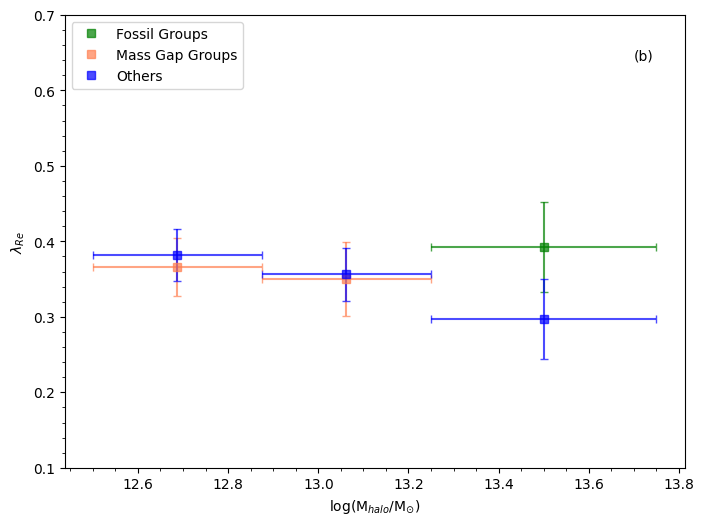

In [42]:
# plot the above
halomasspoints = [12.6875,13.0625,13.5]
halomassbins = np.array([0.1875,0.1875,0.25])

plt.figure(figsize=(8, 6), dpi=100)
dummy=[]
plt.errorbar(dummy,dummy,fmt='s',c='g',alpha=0.7,label="Fossil Groups")
plt.errorbar(dummy,dummy,fmt='s',c='coral',alpha=0.7,label="Mass Gap Groups")
plt.errorbar(dummy,dummy,fmt='s',c='b',alpha=0.7,label="Others")
plt.legend(loc='upper left')


for i in [2,1,0]:
    fossilmean = np.mean(meanmatchedfossilspins[i])
    fossilspinerror = np.zeros((2,1))
    fossilspinerror[0,0] = fossilmean - np.percentile(meanmatchedfossilspins[i],16)
    fossilspinerror[1,0] = np.percentile(meanmatchedfossilspins[i],84) - fossilmean
    
    NFmean = np.mean(meanmatchedNFspins[i])
    NFspinerror = np.zeros((2,1))
    NFspinerror[0,0] = NFmean - np.percentile(meanmatchedNFspins[i],16)
    NFspinerror[1,0] = np.percentile(meanmatchedNFspins[i],84) - NFmean
    
    if i == 2:
        fossilserror = plt.errorbar(halomasspoints[i],fossilmean,yerr=fossilspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='g',alpha=0.7)
        nonfossilerrors = plt.errorbar(halomasspoints[i], NFmean,yerr=NFspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='b', alpha = 0.7)
    if i == 1:
        fossilserror = plt.errorbar(halomasspoints[i],fossilmean,yerr=fossilspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='coral',alpha=0.7)
        nonfossilerrors = plt.errorbar(halomasspoints[i], NFmean,yerr=NFspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='b', alpha = 0.7)
    if i == 0:
        fossilserror = plt.errorbar(halomasspoints[i],fossilmean,yerr=fossilspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='coral',alpha=0.7)
        nonfossilerrors = plt.errorbar(halomasspoints[i], NFmean,yerr=NFspinerror, xerr=halomassbins[i],fmt='s',capsize=3,c='b', alpha = 0.7)
        
plt.ylabel(r"$\lambda_{Re}$")
plt.xlabel(r"log(M$_{halo}$/M$_{\odot}$)")
plt.ylim(0.1,0.7)
plt.legend(loc='upper left')
plt.text(13.7,0.64,'(b)')
plt.minorticks_on()

# save the plot
filename = "/suphys/fscu5535/python_scripts/figures/fossilmggspin.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)

In [64]:
# read in sam's age data and plot vs spin
ages = Table.read('/suphys/fscu5535/python_scripts/raw_data/SAMI_1Re_stellarpops_combined_SamVaughan_13Aug2021.csv')
ages.info()

<Table length=3426>
           name             dtype     class     n_bad
-------------------------- ------- ------------ -----
                     CATID   int64       Column     0
              quick_SN_1Re float64       Column     0
          has_ppxf_fit_1Re    str5       Column     0
               ppxf_SN_1Re float64 MaskedColumn   369
             logage_MW_1Re float64 MaskedColumn   369
        metallicity_MW_1Re float64 MaskedColumn   369
              alpha_MW_1Re float64 MaskedColumn   369
             logage_LW_1Re float64 MaskedColumn   369
        metallicity_LW_1Re float64 MaskedColumn   369
              alpha_LW_1Re float64 MaskedColumn   369
             ppxf_chi2_1Re float64 MaskedColumn   369
                 sigma_1Re float64 MaskedColumn   369
  fraction_last_Gyr_MW_1Re float64 MaskedColumn   369
fraction_less_solar_MW_1Re float64 MaskedColumn   369
  fraction_last_Gyr_LW_1Re float64 MaskedColumn   369
fraction_less_solar_LW_1Re float64 MaskedColumn   369


In [65]:
# for repeated cubes, extract the data with the highest S/N

# first find all the repeated CATIDs
repeatedCATIDs = list()
repeatedCATIDSN = list()
for i in range(len(ages)):
    for j in range(i+1,len(ages)):
        if ages['CATID'][i] == ages['CATID'][j] and ages['CATID'][i] not in repeatedCATIDs:
            repeatedCATIDs.append(ages['CATID'][j])
            break
            
print(len(repeatedCATIDs))
    
    
# # good, now compare S/N data for repeated cubes and pick the best one
# bestbestSNs = list()
# bestbestCATID = list()
# for i in range(len(repeatedCATIDs)):
#     bestSN = i
#     for j in range(1,len(repeatedCATIDs)):
#         if repeatedCATIDSN[i] < repeatedCATIDSN[j]:
#             bestSN = j
    
    

252


In [69]:
# checking that our repeatedCATIDs are truly repeats
ids = []
for i in range(len(repeatedCATIDs)):
    count = 0
    for j in range(len(ages)):
        if repeatedCATIDs[i] == ages['CATID'][j]:
            count += 1
    
    ids.append(count)

print(ids)

[2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 4, 4, 2, 3, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 4, 4, 2, 2, 2, 3, 4, 4, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 3, 2, 3, 3, 3, 2, 4, 4, 2, 3, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 4, 4, 3, 4, 3, 2, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2]


In [81]:
# try grouping by catid
groupedages = ages.group_by('CATID')
groupedages.sort(['CATID','quick_SN_1Re'])
print(groupedages.groups[200]['CATID'])
print(groupedages.groups[200]['quick_SN_1Re'])
print(groupedages.groups[200]['logage_LW_1Re'])
print(groupedages.groups[200]['logage_MW_1Re'])

CATID
-----
49702
49702
49702
   quick_SN_1Re   
------------------
   42.743688701419
 51.24225760388137
63.451386406292016
  logage_LW_1Re  
-----------------
9.306901314878946
 9.31643661304594
 9.33172711228443
  logage_MW_1Re  
-----------------
9.924675672775304
9.955090980214218
 9.95745060499016


In [79]:
# check if the best SN cube always has a non 'nan' logage_LW_1Re
for i in range(len(groupedages.groups)):
    if len(groupedages.groups[i]) > 1 and str(groupedages.groups[i]['logage_LW_1Re']) == 'nan':
        print(groupedages.groups[i]['CATID'])
        print(groupedages.groups[i]['quick_SN_1Re'])
        print(groupedages.groups[i]['logage_LW_1Re'])

# so yes, it does.



In [80]:
# extract logage_LW_1Re values, 1 per CATID
age_LW = []
age_MW = []
corrCATID = []

for i in range(len(groupedages.groups)):
    age_LW.append(groupedages.groups[i]['logage_LW_1Re'][-1])
    corrCATID.append(groupedages.groups[i]['CATID'][-1])
    age_MW.append(groupedages.groups[i]['logage_MW_1Re'][-1])
    
ageTable = Table()
ageTable['CATID'] = corrCATID
ageTable['logage_LW_1Re'] = age_LW
ageTable['logage_MW_1Re'] = age_MW

ageTable.info()

for i in range(len(ageTable)):
    if ageTable['CATID'][i] == 49702:
        print(ageTable[i])
    

<Table length=3067>
     name      dtype     class     n_bad
------------- ------- ------------ -----
        CATID   int64       Column     0
logage_LW_1Re float64 MaskedColumn   313
logage_MW_1Re float64 MaskedColumn   313
CATID  logage_LW_1Re    logage_MW_1Re  
----- ---------------- ----------------
49702 9.33172711228443 9.95745060499016


In [86]:
# data lokos good. now left join to mass gaps data and save
data.info()
data = join(data,ageTable,keys='m1_CATAID',join_type='left')
data.info()
data.write('/suphys/fscu5535/python_scripts/mod_data/massGaps6.0.fits')

<Table length=552>
      name        dtype   unit     class     n_bad
---------------- ------- ------ ------------ -----
         GroupID   int32        MaskedColumn     0
       m1_CATAID   int64        MaskedColumn     0
       m2_CATAID   int64        MaskedColumn     0
              m1 float32              Column     0
              m2 float32              Column     0
           m1-m2 float32              Column     0
   m1_LAMBDAR_RE float64              Column   120
            Nfof   int16        MaskedColumn     0
           MassA float32 Msun/h       Column     0
   log(MassA)/m1 float64              Column     0
         SatMean float32              Column     0
       SatMedian float32              Column     0
      m1-SatMean float32              Column     0
    m1-SatMedian float32              Column     0
      log(MassA) float64              Column     0
IntermediateMean float32              Column     0
      m1-IntMean float32              Column     0
   LAMBDAR_R